In [1]:
## commong packages for CUSP NYU PUI class

#from __future__ import print_function, division
#import geopandas as gp
import numpy as np
#import pandas as pd
import os
#import json
import pylab as pl
from pandas.tools.plotting import scatter_matrix
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#import datetime as dt
#import scipy
#import scipy.stats

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [ ]:
#To take information from datafacility
os.getenv("DFDATA")

### Downloading from web

In [ ]:
df_pop=pd.read_csv("API_SP.POP.TOTL_DS2_en_csv_v2.csv", skiprows=(0,2)) #Population, we are skipping rows because the first two 
                                                                        #don't have relevant information

In [ ]:
#download, move data to $PUIDATA, and read data in 
!curl -O https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv
cmd = "mv rows.csv " + os.getenv("PUIDATA")
#the line below is to check that my string is formatted right. I should remove it to make the notebook delivery ready
print (cmd)


In [ ]:
#Para json, el de abajo. También es importante asegurar reproducibilidad.
json_data=open('/home/cusp/jss895/PUI2017/PUIdata/vehicle-monitoring.json').read()
data = json.loads(json_data)

### Unziping in place 

In [ ]:
#to unzip in specific place
os.system("unzip  -d %s mn_mappluto_16v1.zip"%(os.getenv("PUIDATA") + '/Manhattan'))

In [ ]:
#to list was in the directory
#cmd = "ls " + os.getenv("PUIDATA")+"/Manhattan"
#print (cmd)
#os.system(cmd)
!ls $PUIDATA/Manhattan/*

### Data Cleaning

In [ ]:
#check data looking at it columns after importing
df.columns

In [ ]:
# Check which is the indexing column
df.index

In [ ]:
# Resetting index
df.set_index("column", inplace=True) #el inplace reemplaza el df original

In [ ]:
#sus sampling by broadcasting
test=df[::100]

In [ ]:
#check number os NaNs in a colum
df["column"].isnull().sum()

In [ ]:
df.dropna(subset=["column"],inplace=True) #el inplace reemplaza el dataframe original

In [ ]:
df.groupby(by="column").mean() #le tenés que pedir una operación al group by, dame la media de cada borough en cada grupo

In [ ]:
# converting  the relevant columns to numeric values and throwing away spurious entries
df['column'] = pd.to_numeric(df['column'], errors='corece')

In [ ]:
#the pd.to_numeric function does the same in a single line!!
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = \
            pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], 
                          errors='coerce').astype(float)
#the line below checks that the conversion worked. should be removed in delivery ready ipynb
#nrg['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)

In [ ]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

In [ ]:
nrg.rename(columns={'NYC Borough, Block, and Lot (BBL)':'BBL', 
                    'Reported Property Floor Area (Building(s)) (ft²)':'Reported Property Floor Area'}, 
           inplace=True)
nrg.head()

In [ ]:
#Dropping unncesary columns
df=df[["column1","column10"]]


In [ ]:
#transforming to datetime
df_sm['DateSampled'] = pd.to_datetime(df_sm['Date Sampled'])

#to check conversion was succesfull
df_sm.DateSampled.describe()

In [ ]:
#Así convertimos una variable en float, suponiendo que no tiene valores raros.
data["nombrevariable"] = data["nombrevariable"].astype(float)

#Así le damos nuevos valores a los que ya estaban en una columna, cambiamos por ejemplo "Female" por 2.
data.gender = data.gender.replace(2, "Female")

# Merge basados en una columna que tiene el mismo nombre en ambas bases de datos.
df = pd.merge(data, nrg, on="BBL")

#Merge utilizando columnas con mismo significado pero diferente nombre
data = pd.merge(df, df1, right_on="Country Name", left_on="Country")

#TENER CUIDADO SI QUEREMOS HACER UN INNER O UN OUTER MERGE.

#Concatenate hacia abajo. Es decir poniendo una base de datos abajo de la otra.
df1.columns = df.columns
data = pd.concat([df, df1])

#Concatenar de modo horizontal, es decir agregando una nueva columna a la base de datos.
data = pd.concat([time311, timeNYPD], axis = 1, join = "outer")


In [ ]:
#merging columns
df = df_pop.merge(df_gdp, right_on="Country Name", left_on="Country Name")
df = df.merge(df_ms,  right_on="Country", left_on="Country Name")
df = df.merge(df_mur,  right_on="Country/Territory", left_on="Country Name")

In [ ]:
#Split by hour
cb2015['dayride'] = (cb2015.starthour.values > 6) & (cb2015.starthour.values < 6)

### Advanced data cleaning

In [ ]:
# Generar función para crear nueva columna. Ejemplo uno para datetime. Ejemplo dos para locación
def time_checker(t):
    if t > nightstart:
        return 'Night Rider'
    if t < nightend:
        return 'Night Rider'
    else:
        return 'Day Rider'

df['typee'] = df['time'].apply(lambda x: time_checker(x))


def borough(xy):
    x,y = xy
    if (x>40.698215)&(y<-73.970755):
        return "Manhattan"        
    else:
        return "Brooklyn"
    
data["borough"] = data[["start station latitude","start station longitude"]].apply(borough, axis=1)

In [ ]:
#defines a function that to place statin in BL or M based on 2 points

x1 = (40.738102, -73.962194)
x0 = (40.694456, -74.012116)

def manORbk(coords):
    ''' defined points in BK or Manhattan based on position w respect to a single boundary line
    Arguments:
    coords: (lat, lon) tuple or 1D array of size 2, coordinates in degrees
    returns: character "M" or "B" for Manhattan and Brooklyn respectively
    '''
    lat,lon = coords
    #print (lat, lon)
    if lat >= x1[0] :
        #print (1)
        return 'M'
    elif lat <= x0[0] :
        #print (2)
        return 'B'
    elif lon > 1.143793 * lat -120.558150:
        #print (3, 1.143793 * lat -120.558150)
        return 'B'
    else: 
        #print (4, 1.143793 * lat -120.558150, lon > 1.143793 * lat -120.558150)
        return 'M'

In [ ]:
#test function
manORbk((40.68807003, -73.98410637))

In [ ]:
#this cells passes coordinates to manORbk
cb2015['latlon'] = [(lat,lon) for lat, lon in latlon]
cb2015['MorBK'] = cb2015['latlon'].apply(manORbk)

In [ ]:
#since we are only interested in the stations position, all the duplicates are dropped
statsionsDF = cb2015.drop_duplicates(subset=["latlon",
                                             "MorBK",
                                             "BK", "M"])


### Exploring Dataa

In [ ]:
# Para ver las primeras filas de la base de datos
data.head()

# Para ver todas las columnas (variables)
data.columns

# Para ver la forma
data.shape

# Para una breve descripción de media, desviación estandar, mínimo, máximo, etc.
data.describe()

#También se pueden conseguir por separado.
data["LotArea"].std()
data["LotArea"].mean()

#Usualmente esto se acompaña de un scatterplot, pero será el primero de los que veamos en la sección PLOTTING.

#scatter matrix
sfig = scatter_matrix (nrg, s=300, figsize=(10, 10), diagonal='kde')

In [ ]:
#checking outliers
df_pop=pd.read_csv("API_SP.POP.TOTL_DS2_en_csv_v2.csv", skiprows=(0,2)) #Population, we are skipping rows because the first two 
                                                                        #don't have relevant information

#### Plotting Histograms by date and two groups (HW4)

In [ ]:
# plot daytime trip duration histogram in 100 bins
# plot 0% to 95% percentile because I expect these distribution to be long tailed and I see 43,000 hour trips above
pc = np.percentile(cb2015.tripduration, [0, 99])
bins = np.linspace(int(pc[0]), int(pc[1] / 100) * 100, 100)
dayax = cb2015[cb2015.dayride].tripduration.groupby(
    pd.cut(cb2015[cb2015.dayride].tripduration, bins)).\
                    agg([count_nonzero]).plot(kind='bar', legend=False)
dayax.set_title("Jan and June 2015 rides")
# plot nighttime trip duration histogram
cb2015[~cb2015.dayride].tripduration.groupby(
    pd.cut(cb2015[~cb2015.dayride].tripduration, bins)).\
                    agg([count_nonzero]).plot(kind='bar', legend=False, ax=dayax, 
                                             color='IndianRed')
xlab = dayax.get_xticklabels()
dayax.set_xticklabels(['' if float(i)%10 > 0 else xlab[i] for i in range(len(xlab))]);
dayax.set_xlabel(" trip duration (minutes)");



#También graficó cómo hacer las funciones acumuladas en ese mismo homework, estaba bueno. También plotea la diferencia.

In [ ]:
#plotting with error bars
fig, ax = plt.subplots()

scatter = ax.scatter(df_.gdp * 1e-12, df_['Number of mass shootings'])
ax.errorbar(df_.gdp * 1e-12, df_['Number of mass shootings'], 
            yerr = np.sqrt(df_['Number of mass shootings'] * 1.0), fmt = '.')
ax.set_xlabel("GDP (in tillion $)")
ax.set_ylabel("Number of mass shooting per person")
ax.set_ylim();

In [ ]:
#plotting with different color
ax.scatter(df_[df_["Country"] == 'United States'][u'Average total all civilian firearms'] / 
           df_[df_["Country"] == 'United States']['pop'], 
                     df_[df_["Country"] == 'United States']['Number of homicides by firearm'] / 
           df_[df_["Country"] == 'United States']['pop'] * 1e5, color='r', alpha=1)

### Fitting distributions

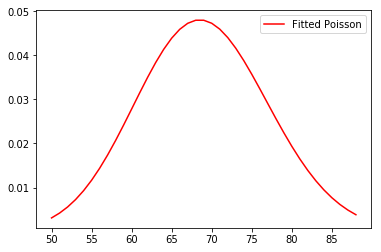

In [83]:
#Creating an idealized distribution of a poisson with 69 lambda
from scipy.stats import poisson

fig, ax = plt.subplots(1, 1)
mu=69

x = np.arange(poisson.ppf(0.01, mu), poisson.ppf(0.99, mu))
ax.plot(x, poisson.pmf(x, mu), 'r', color="red",ms=8, label='Fitted Poisson') #this makes a line
ax.legend()
#ax.vlines(x, 0, poisson.pmf(x, mu), colors='black', lw=5, alpha=0.5); #this makes bins


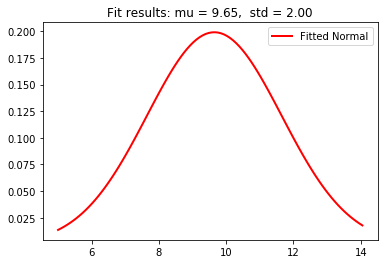

In [101]:
#Creating an idealized distribution of Normal distribution
from scipy.stats import norm

# Generate some data for this demonstration.
#data = norm.rvs(0, 1, size=100)
data=2*random.randn(100)+10

# Fit a normal distribution to the data:
mu, std = norm.fit(data)


# Plot the histogram.
#plt.hist(data, bins=25, normed=True, alpha=0.6, color='g')

#this is to acquiere the limits of the original histogram
#xmin, xmax = plt.xlim()

# Plot the PDF.
x = np.linspace(data.min(),data.max(), 100) #this should be adapted to the scale fitted
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2,label="Fitted Normal",color="red")
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.legend()
plt.title(title)

plt.show()

En HW5_1 hay más maneras

### Statistical Test (HW4)

KS and AD to compare goodness of fit
#Remember they must have similar mean and SD

In [ ]:
print ("normal on normal", scipy.stats.kstest(dist_n,'norm'))
print ("normal on normal", scipy.stats.anderson(dist_n, dist='norm'))
print ("") 

In [ ]:
# Comparing sample and population
z = (df - df.mean()) / (timesOldStd / np.sqrt(len(timesNew)))
print("The Z statistics is Z = {0:.2f}".format(Z))

In [ ]:
def chisq(model, data):
    errors = np.sqrt(data)
    return ((model - data)**2 / errors**2).sum()
print (chisq(model, hsbins[0]))

#### KS tests to compare 2 samples

http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.ks_2samp.html

Null: the two distribution come from the same parent distribution

In [ ]:
ks = scipy.stats.ks_2samp(cb2015[cb2015.dayride].tripduration, cb2015[~cb2015.dayride].tripduration)
print (ks)

In [ ]:
scipy.stats.pearsonr

Note on the KS test: the KS test, and generally any test of Null Hypothesis Statistical Testing, has higher power for larger samples. With a million observations, 100s of thousands in each sample tiny differences tend to become statistically significant. (The distribution looked different by eye in a cumulative plot in the testig phase, with 1000 fewer samples but the p-value was less significant)

#### Pearson tests to compare 2 samples

This checks for correlation between the two samples. Note that this is not a rigorous test, unlike the KS test, and according to scipy.stats.pearsonr _"The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so."_


Note that the data should be sorted and also the two samples need to have the same size.
For this:

In [ ]:
#sorting and sampling day toa smaller size
df1=df1.sample(len(df2)).sort_values('column')
df2=df2.sort_values('column')

scipy.stats.pearsonr(df1.sample(len(df2)).sort_values('column'),df2.sort_values('column'))

In [ ]:
#As FB did it:
scipy.stats.pearsonr(np.sort(dfday.tripduration), np.sort(cb2015[~cb2015.dayride].tripduration))

### Spearman tests to compare 2 samples

In [ ]:
scipy.stats.spearmanr(np.sort(dfday.tripduration), np.sort(cb2015[~cb2015.dayride].tripduration))
scipy.stats.pearsonr(df1,df2)

This test is often used to assess if sample are generated by the same distribution but in fact it tests if the samples are generated by correlated distributions. As a test to assess independence it is not powerful, as even a small amount of correlation would raise the p-value

Not Reject NULL:
"The Null hypothesis that the two samples are generated from uncorrelated distributions cannot be rejected (alpha=0.05)"

Reject NULL:
The Null hypothesis that the two samples are generated from uncorrelated distributions is rejected (alpha=0.05)


### Modeling

In [ ]:
import statsmodels.formula.api as st
import statsmodels as sm
import seaborn as sns
import statsmodels.graphics.regressionplots

In [ ]:
## ADS Style

#Importing all the package needed for the answers.
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
%matplotlib inline


#With the statisical package we build a linear model
lm = smf.ols(formula="AssessTot ~ LotArea", data = data_4).fit()
lm.summary()


#Visualizing the model 

plt.figure()
plt.scatter("LotArea","AssessTot",data=data_4)
plt.plot(data_4["LotArea"],data_4.pred,c="r")
plt.xlabel('Total area of the tax lot')
plt.ylabel('Assessed total value')
plt.title("Total Asset vs Lot Area")
plt.show()

#[data_4["LotArea"]<20000]

In [ ]:
W1 = model.params[1]
W2 = model.params[0] 

wmodel2 = model2.params[0]

plt.scatter("firearmspp", "masshootingpp", data = df,label="")
plt.plot(df["firearmspp"], W1*df["firearmspp"] + W2, c="r",label="OLS fit")
plt.plot(df["firearmspp"], wmodel2*df["firearmspp"], c="g",label="WLS fit")

plt.xlabel("Fire arms per person")
plt.ylabel("Mass Shootings per million people")
plt.legend()
plt.title("Mass shootings per person in function of Fire arms per person (OLS)", weight='bold', fontsize=14);

In [ ]:
# Plot with confidence intervals
sns.regplot(x=df.firearmspp, y=df.masshootingpp, data=df)
plt.xlabel("Fire arms per person")
plt.ylabel("Mass Shootings per million people")
plt.title("Mass shootings per person in function of Fire arms per person (OLS)", weight='bold', fontsize=14);

In [ ]:
#Plot for assesing leverage
import statsmodels.api as sm
sm.graphics.influence_plot(modelOLS, alpha  = 0.05, criterion="cooks");

In [ ]:
#Definint chi squeare

def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        errors = np.ones_like(data)
    if data.shape == model.shape and data.shape == errors.shape:
        return (((data - model)**2) / errors**2).sum()
    else: 
        print ('''ERROR:
must pass arrays of identical dimension for data, model and (optional) error)''')
    return -1

In [ ]:

#Compare the fit with chi square:


#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = min(len(bblnrgdataCut.UnitsTotal) - np.isnan(bblnrgdataCut.UnitsTotal).sum(), 
         len(bblnrgdataCut.nrg) - np.isnan(bblnrgdataCut.nrg).sum()) - 2
print ("degrees of freedom:" , dof)





In [ ]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict()) / float(dof)))

print ("Units vs Energy chi square per DOF w IV error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = bblnrgdataCut.errorsunits) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + bblnrgdataCut.errorsunits**2))  / dof))

In [ ]:
#building a cuadratic fit using number of units as independent variable
import statsmodels.formula.api as smf

cuadmodel=smf.ols(formula="log10(y)~I(log10(x)**2)+log10(x)",data=bblnrgdata_cut).fit()
cuadmodel.summary()

In [ ]:
#building a cuadratic fit using number of units as independent variable
import statsmodels.formula.api as smf

cuadmodel=smf.ols(formula="log10(y)~I(log10(x)**2)+log10(x)",data=bblnrgdata_cut).fit()
cuadmodel.summary()

In [ ]:
#using LR to compare both models
print ("LR : ", -2 * (-linmodel.llf - (-cuadmodel.llf)))
print ("LR from statsmodels:", cuadmodel.compare_lr_test(linmodel))